In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from models import SEM, KerasLDS, LinearDynamicSystem, KerasMultiLayerNN
from models import KerasSimpleRNN, KerasGRU
from sklearn import metrics

Using TensorFlow backend.


Here, I'm defining the event segmentation model and a linear dymanic system that is used as the event model. See SEM project notes for details, but it's what's proposed


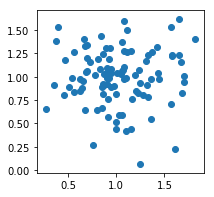

In [2]:
def build_2d_data(N, beta=0.1):
    """ 
    2d, Mulitvariate Guassian data
    """
    mu = [1, 1]
    Sigma = np.eye(2) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    for n in range(N):
        x[n, :] = np.random.multivariate_normal(mu, Sigma)
        
    return x
X = build_2d_data(100)
plt.figure(figsize=(3,3))
plt.scatter(X[:,0], X[:, 1])

In [3]:
D = 2
X_train = X[0:-1]; y_train = X[1:]

Now, we define some toy problem

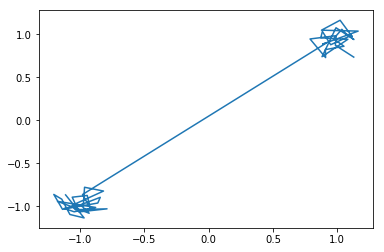

In [4]:
# first demo -- gaussian mixture defined by the CRP

def build_static_dataset(N, beta=0.1):
    """ 
    2 events, modeled as gaussians with different means
    """
    
    pi = np.array([0.4, 0.6])
    mus = [[1, 1], [-1, -1]]
    x = np.zeros((N, 2), dtype=np.float32)
    for n in range(N/2):
        x[n, :] = np.random.multivariate_normal(mus[0], np.eye(2) * beta)
    for n in range(N/2, N):
        x[n, :] = np.random.multivariate_normal(mus[1], np.eye(2) * beta)
        
    return x

x_train = build_static_dataset(50, 0.01)
y = np.concatenate([np.zeros((25), dtype=int), np.ones((25), dtype=int)])
plt.plot(x_train[:, 0], x_train[:, 1])

In [5]:
# SEM parameters
K = 20  # maximum number of event types
lmda = 10  # stickyness parameter
alfa = 1.00  # concentration parameter
beta = 0.1 # transition noise
eta =  0.1  # learning rate


# define plotting function
import seaborn as sns

def plot_segmentation(post, y):
    cluster_id = np.argmax(post, axis=1)
    cc = sns.color_palette('Dark2', post.shape[1])
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
    for clt in cluster_id:
        idx = np.nonzero(cluster_id == clt)[0]
        axes[0].scatter(x_train[idx, 0], x_train[idx, 1], color=cc[clt], alpha=.5)
        
    axes[1].plot(post)
    y_hat = np.argmax(post, axis=1)
    print "Adjusted Mutual Information:", metrics.adjusted_mutual_info_score(y, y_hat)
    print "Adjusted Rand Score:", metrics.adjusted_rand_score(y, y_hat)
    print 
    print np.argmax(post, axis=1)

### Linear dynamical solution (analytic)

Widget Javascript not detected.  It may not be installed or enabled properly.



Adjusted Mutual Information: -8.17446246292e-17
Adjusted Rand Score: 0.0

[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


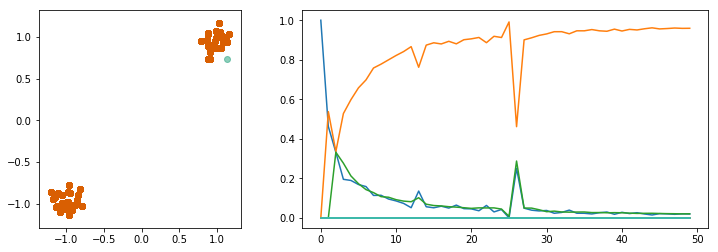

In [6]:
sem_kwargs = dict(lmda=lmda, alfa=alfa, beta=beta, 
                  f_class=LinearDynamicSystem, f_opts=dict(eta=eta))
sem = SEM(**sem_kwargs)
post = sem.run(x_train, K=K)
plot_segmentation(post, y)

### Linear dynamical system (Keras estimate)

Widget Javascript not detected.  It may not be installed or enabled properly.


/Users/nickfranklin/anaconda/envs/tensorflow/lib/python2.7/site-packages/keras/models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '



Adjusted Mutual Information: -0.0223100163923
Adjusted Rand Score: -0.00270207928296

[0 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 3 4 5 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2]


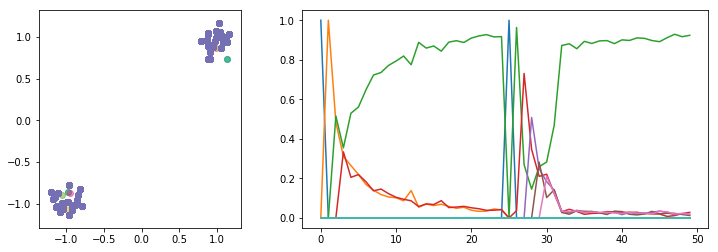

In [7]:
# Initialize keras model
sem_kwargs2 = dict(lmda=lmda, alfa=alfa, beta=beta, 
                  f_class=KerasLDS, f_opts=dict())

sem2 = SEM(**sem_kwargs2)
post = sem2.run(x_train, K=K)
tf.Session().close()
plot_segmentation(post, y)

### Multilayer NN with nonlinear hidden layer

Widget Javascript not detected.  It may not be installed or enabled properly.



Adjusted Mutual Information: 0.695615946494
Adjusted Rand Score: 0.846241153692

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


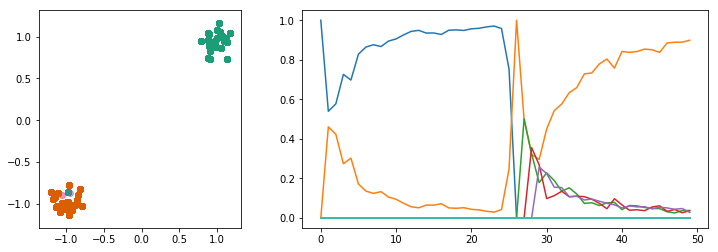

In [8]:
# Initialize keras model
sem_kwargs3 = dict(lmda=lmda, alfa=alfa, beta=beta, 
                  f_class=KerasMultiLayerNN, f_opts=dict())

sem3 = SEM(**sem_kwargs3)
post = sem3.run(x_train, K=K)
tf.Session().close()
plot_segmentation(post, y)

### Recurrent, Multilayer NN 

Widget Javascript not detected.  It may not be installed or enabled properly.



Adjusted Mutual Information: 0.515275301289
Adjusted Rand Score: 0.737652255387

[0 1 2 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 5 6 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4]


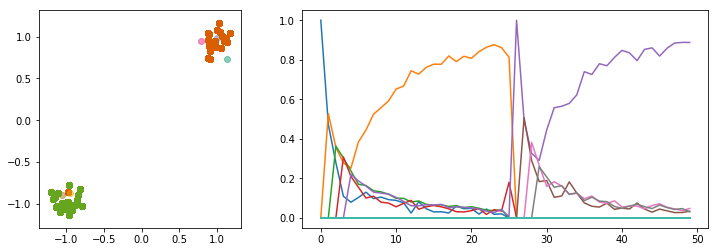

In [9]:
# Initialize keras model
sem_kwargs4 = dict(lmda=lmda, alfa=alfa, beta=beta, 
                  f_class=KerasSimpleRNN, f_opts=dict(t=5))

sem4 = SEM(**sem_kwargs4)
post = sem4.run(x_train, K=K)
tf.Session().close()
plot_segmentation(post, y)

# Gated Recurrent NN

Widget Javascript not detected.  It may not be installed or enabled properly.



Adjusted Mutual Information: 0.694781322926
Adjusted Rand Score: 0.846220619658

[0 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3]


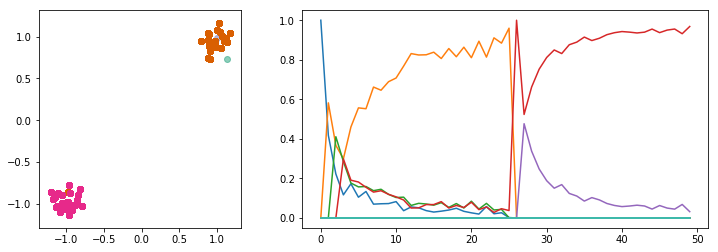

In [10]:
# Initialize keras model
sem_kwargs5 = dict(lmda=lmda, alfa=alfa, beta=beta, 
                  f_class=KerasGRU, f_opts=dict(t=5))

sem5 = SEM(**sem_kwargs5)
post = sem5.run(x_train, K=K)
tf.Session().close()
plot_segmentation(post, y)

# Alternating between 2 static events


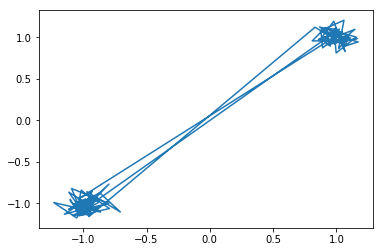

In [11]:
def build_alternating_static_events(N, beta=0.1):
    """ 
    2 alternating events, modeled as gaussians with different means
    """
    
    pi = np.array([0.4, 0.6])
    mus = [[1, 1], [-1, -1]]
    stds = np.ones((2, 2)) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    for n in range(N/4):
        x[n, :] = np.random.multivariate_normal(mus[0], np.diag(stds[0]))
    for n in range(N/4, N/2):
        x[n, :] = np.random.multivariate_normal(mus[1], np.diag(stds[1]))
    for n in range(N/2, N/4*3):
        x[n, :] = np.random.multivariate_normal(mus[0], np.diag(stds[0]))
    for n in range(N/4*3, N):
        x[n, :] = np.random.multivariate_normal(mus[1], np.diag(stds[1]))
        
    return x

x_train = build_alternating_static_events(100, 0.01)
y = np.concatenate([np.zeros(25, dtype=int), np.ones(25, dtype=int), np.zeros(25, dtype=int), np.ones(25, dtype=int)])
plt.plot(x_train[:, 0], x_train[:, 1])

### Linear dynamical solution (analytic)

Widget Javascript not detected.  It may not be installed or enabled properly.



Adjusted Mutual Information: 0.214532905348
Adjusted Rand Score: 0.205271067776

[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


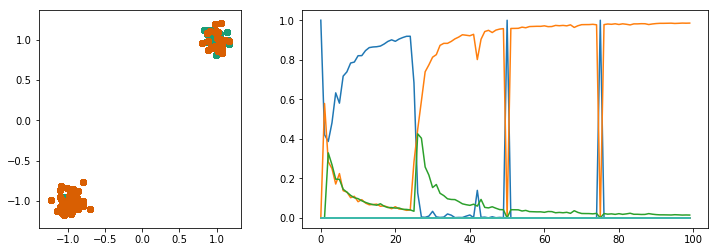

In [12]:
sem = SEM(**sem_kwargs)
post = sem.run(x_train, K=K)
plot_segmentation(post, y)

### Linear dynamical system (Keras estimate)

Widget Javascript not detected.  It may not be installed or enabled properly.



Adjusted Mutual Information: 0.737850415069
Adjusted Rand Score: 0.902117158709

[0 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 3 4 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


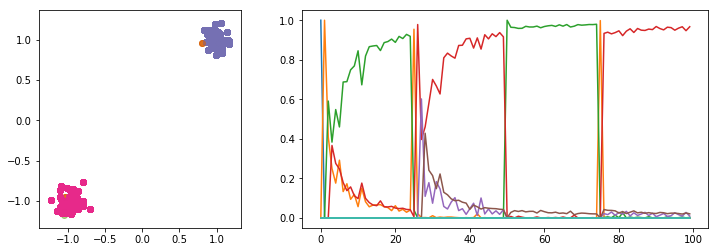

In [13]:
sem2 = SEM(**sem_kwargs2)
post = sem2.run(x_train, K=K)
tf.Session().close()
plot_segmentation(post, y)

### Multilayer NN with nonlinear hidden layer

Widget Javascript not detected.  It may not be installed or enabled properly.



Adjusted Mutual Information: 0.865924950396
Adjusted Rand Score: 0.940588602712

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


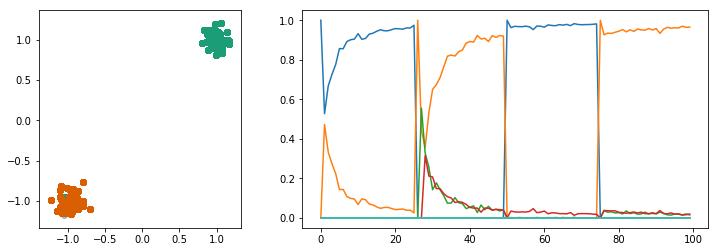

In [14]:
sem3 = SEM(**sem_kwargs3)
post = sem3.run(x_train, K=K)
tf.Session().close()
plot_segmentation(post, y)

### Recurrent, Multilayer NN 

Widget Javascript not detected.  It may not be installed or enabled properly.



Adjusted Mutual Information: 0.739265187666
Adjusted Rand Score: 0.902521235001

[0 1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 3 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


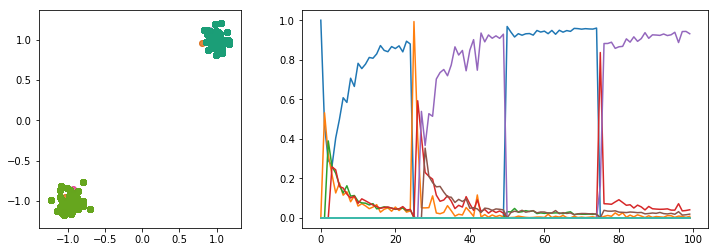

In [15]:
sem4 = SEM(**sem_kwargs4)
post = sem4.run(x_train, K=K)
tf.Session().close()
plot_segmentation(post, y)

## Gated recurrent units

Widget Javascript not detected.  It may not be installed or enabled properly.



Adjusted Mutual Information: 0.871891670714
Adjusted Rand Score: 0.959980073743

[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


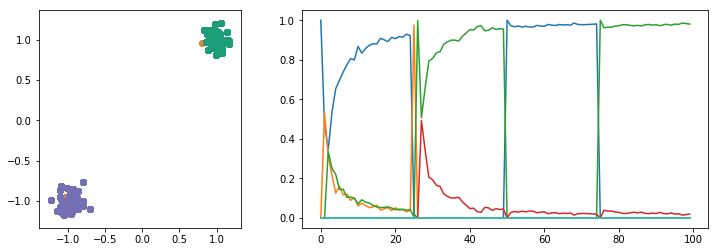

In [16]:
sem5 = SEM(**sem_kwargs5)
post = sem5.run(x_train, K=K)
tf.Session().close()
plot_segmentation(post, y)

# Example of four events where the events correspond to movement in vector space

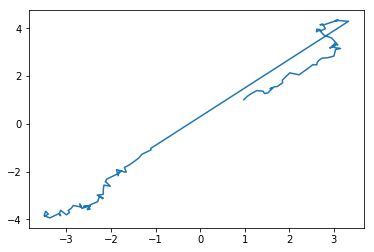

In [17]:
def build_moving_data(N, beta=0.01):
    pi = np.array([0.4, 0.6])
    bs = [[1, 1], [-1, -1]]  # starting point!
    ws = [np.array([[1, 0], [.5, 2]]), np.array([[-1, .2], [-.2, 1]])]
    stds = np.eye(2) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    
    x[0, :] = np.random.multivariate_normal(bs[0], stds)
    for n in range(1, N/2):
        _x = x[n-1, :] + np.array([0.05, 0.05])
        x[n, :] = np.random.multivariate_normal(_x, stds)
        
    x[N/2, :] = np.random.multivariate_normal(bs[1], stds)
    for n in range(N/2+1, N):
        _x = x[n-1, :] + np.array([-0.05, -0.05])
        x[n, :] = np.random.multivariate_normal(_x, stds)
    return x

x_train = build_moving_data(100)
y = np.concatenate([np.zeros(50, dtype=int), np.ones(50, dtype=int)])
plt.plot(x_train[:, 0], x_train[:, 1])

### Linear dynamical solution (analytic)

Widget Javascript not detected.  It may not be installed or enabled properly.


models/sem.py:120: RuntimeWarning: divide by zero encountered in log
  lik[k] = np.log(mvnormal.pdf(X_curr - Y_hat, mean=np.zeros(D), cov=Sigma))



Adjusted Mutual Information: 0.00574597413575
Adjusted Rand Score: 0.00680599223229

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  2  3
  4  5  6  7  8  9 10 11  9  9  9  9 12 11 11 11 13 14 15 16  8 17  8 18 18
  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 18 18 19 11
 16 16 16 19 10 15 15 15 15 15 15 14  3  5  4 12 19 13  7  6 17 10 18 14  2]


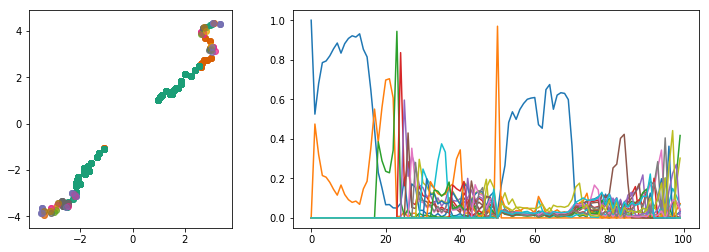

In [18]:
sem = SEM(**sem_kwargs)
post = sem.run(x_train, K=K)
plot_segmentation(post, y)

### Linear dynamical system (Keras estimate)

Widget Javascript not detected.  It may not be installed or enabled properly.



Adjusted Mutual Information: 0.0916778115415
Adjusted Rand Score: 0.0456212904772

[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 2 3 4 5 6 3 3 3 3 3 3 3 3 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


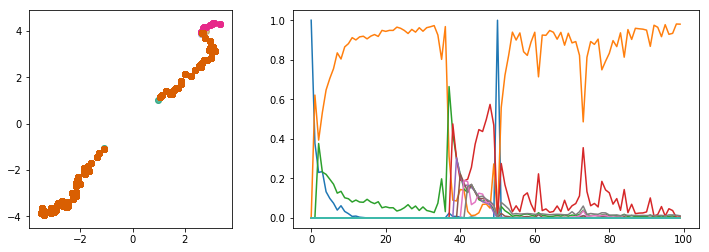

In [19]:
sem2 = SEM(**sem_kwargs2)
post = sem2.run(x_train, K=K)
tf.Session().close()
plot_segmentation(post, y)

### Multilayer NN with nonlinear hidden layer

Widget Javascript not detected.  It may not be installed or enabled properly.



Adjusted Mutual Information: 0.258037597586
Adjusted Rand Score: 0.262291449533

[0 1 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 5
 6 6 6 6 6 6 6 6 6 6 6 6 6 0 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 8 9
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]


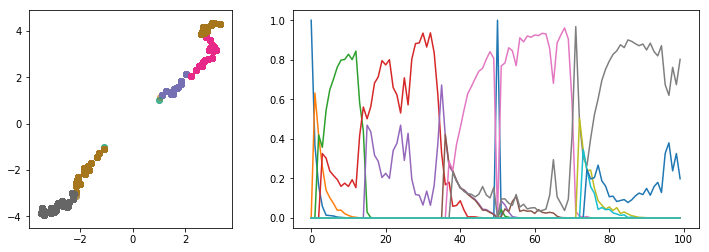

In [20]:
sem3 = SEM(**sem_kwargs3)
post = sem3.run(x_train, K=K)
tf.Session().close()
plot_segmentation(post, y)

### Recurrent, Multilayer NN 

Widget Javascript not detected.  It may not be installed or enabled properly.



Adjusted Mutual Information: 0.270089915615
Adjusted Rand Score: 0.390601034786

[ 0  1  2  2  2  2  2  2  2  2  2  2  2  3  4  4  4  4  4  4  5  6  6  6  6
  6  6  6  6  6  6  6  6  6  6  6  7  8  9 10 11  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


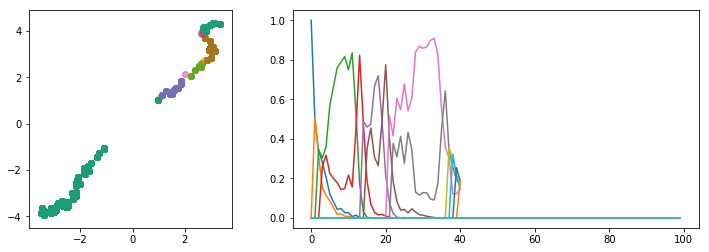

In [21]:
sem4 = SEM(**sem_kwargs4)
post = sem4.run(x_train, K=K)
tf.Session().close()
plot_segmentation(post, y)

## Gated recurrent units

Widget Javascript not detected.  It may not be installed or enabled properly.



Adjusted Mutual Information: 0.13172577304
Adjusted Rand Score: 0.123001730985

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  2  3  2  4  5  6  7  8  9
 10  9  9  9  9  9  9  9  9  9 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


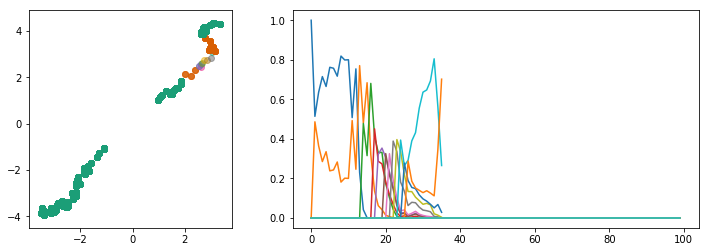

In [22]:
sem5 = SEM(**sem_kwargs5)
post = sem5.run(x_train, K=K)
tf.Session().close()
plot_segmentation(post, y)

# 4 events where the events correspond to movement in vector space


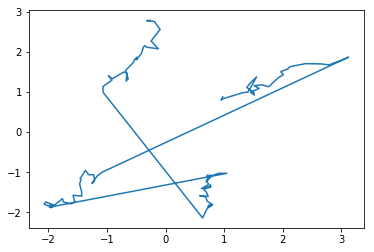

In [23]:
def build_alternating_moving_events(N, beta=0.01):
    pi = np.array([0.4, 0.6])
    bs = [[1, 1], [-1, -1], [1, -1], [-1, 1]]  # starting point!
    ws = [np.array([[1, 0], [.5, 2]]), np.array([[-1, .2], [-.2, 1]])]
    Sigma = np.eye(2) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    
    x[0, :] = np.random.multivariate_normal(bs[0], Sigma)
    for n in range(1, N/4):
        _x = x[n-1, :] + np.array([0.05, 0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)
        
    x[N/4, :] = np.random.multivariate_normal(bs[1], Sigma)
    for n in range(N/4+1, N/2):
        _x = x[n-1, :] + np.array([-0.05, -0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)
            
    x[N/2, :] = np.random.multivariate_normal(bs[2], Sigma)
    for n in range(N/2+1, N/4*3):
        _x = x[n-1, :] + np.array([-0.05, -0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)
        
    x[N/4*3, :] = np.random.multivariate_normal(bs[3], Sigma)
    for n in range(N/4*3+1, N):
        _x = x[n-1, :] + np.array([0.05, 0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)      
        
    return x

x_train = build_alternating_moving_events(100)
y = np.concatenate([np.zeros(25, dtype=int), np.ones(25, dtype=int), 
                    np.ones(25, dtype=int)*2, np.ones(25, dtype=int)*3])

plt.plot(x_train[:, 0], x_train[:, 1])

### Linear dynamical solution (analytic)

Widget Javascript not detected.  It may not be installed or enabled properly.



Adjusted Mutual Information: 0.444035059053
Adjusted Rand Score: 0.459425906861

[0 1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 2 0 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 4 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


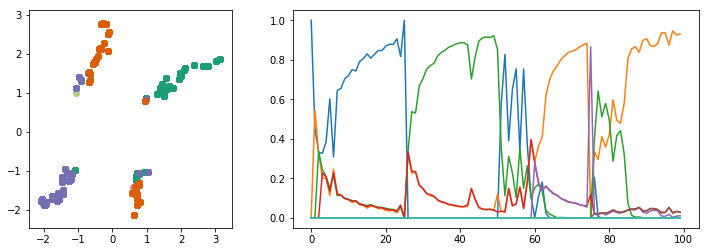

In [24]:
sem = SEM(**sem_kwargs)
post = sem.run(x_train, K=K)
plot_segmentation(post, y)

### Linear dynamical system (Keras estimate)

Widget Javascript not detected.  It may not be installed or enabled properly.



Adjusted Mutual Information: 0.667971280294
Adjusted Rand Score: 0.633673004757

[0 1 2 3 4 0 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 1 5 6 7 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 0 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 5 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]


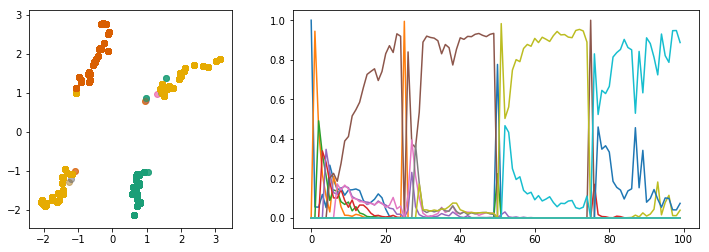

In [25]:
sem2 = SEM(**sem_kwargs2)
post = sem2.run(x_train, K=K)
tf.Session().close()
plot_segmentation(post, y)

### Multilayer NN with nonlinear hidden layer

Widget Javascript not detected.  It may not be installed or enabled properly.



Adjusted Mutual Information: 0.643310465302
Adjusted Rand Score: 0.755198245935

[ 0  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  3  3  3
  0  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  2  4  5  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  3  7  8  9 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 11 11 11 11]


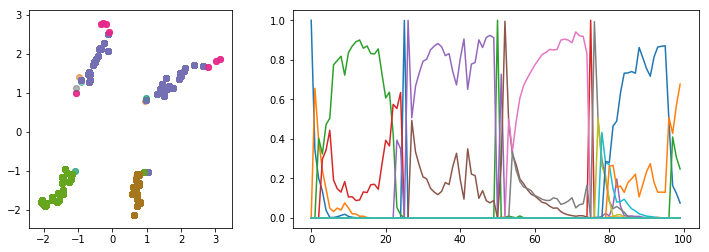

In [26]:
sem3 = SEM(**sem_kwargs3)
post = sem3.run(x_train, K=K)
tf.Session().close()
plot_segmentation(post, y)

### Recurrent, Multilayer NN 

Widget Javascript not detected.  It may not be installed or enabled properly.



Adjusted Mutual Information: 0.586981376489
Adjusted Rand Score: 0.722098659823

[ 0  1  2  3  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  5  5  5  5
  0  6  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  0  8  9 10 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
  1 12 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 14 15 14 16 14]


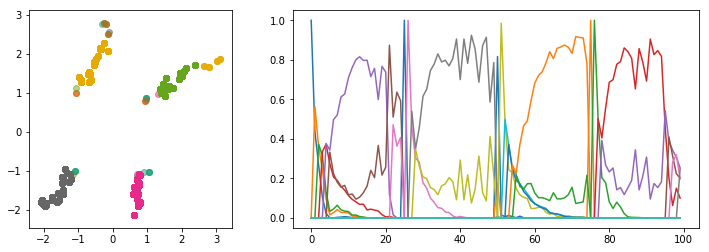

In [ ]:
sem4 = SEM(**sem_kwargs4)
post = sem4.run(x_train, K=K)
tf.Session().close()
plot_segmentation(post, y)

## Gated recurrent units

In [ ]:
sem5 = SEM(**sem_kwargs5)
post = sem5.run(x_train, K=K)
tf.Session().close()
plot_segmentation(post, y)

Widget Javascript not detected.  It may not be installed or enabled properly.
